### Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
import torch.optim as optim

### データの読み込み・変換

In [2]:
# 単位の接頭辞の変換関数
def convert(num):
    list_prefix = ["%","K","M","B"]
    list_order = [10**-2, 10**3, 10**6, 10**9]
    n = len(list_prefix)
    for i in range(n):
        prefix = list_prefix[i]
        order = list_order[i]
        if prefix in num:
            return float(num.replace(prefix,"")) * order
    return float(num)

In [3]:
# csvの読み込み・整形関数
def load_csv_to_df(path):
    # NTT株価データの読み込み
    df = pd.read_csv(path)

    # ラベルを英語に変更
    df.columns = ["date", "close", "open", "high", "low", "volume", "change_rate"]

    # 日付けをdatetime型に変更
    df["date"] = pd.to_datetime(df["date"])

    # 出来高,変化率をfloat型に変換
    df["volume"] = df["volume"].apply(convert)
    df["change_rate"] = df["change_rate"].apply(convert)

    return df

In [4]:
# csvの読み込み
df = load_csv_to_df("C:/Users/harry/Downloads/課題/stock_price.csv")

# 株価データの確認
print(df)

           date  close   open   high    low        volume  change_rate
0    2024-08-01  156.3  159.3  159.4  156.1  7.915000e+07      -0.0256
1    2024-07-31  160.4  158.2  160.7  158.1  1.739100e+08       0.0107
2    2024-07-30  158.7  158.8  159.2  158.0  1.381400e+08      -0.0063
3    2024-07-29  159.7  158.7  160.2  158.4  1.262800e+08       0.0114
4    2024-07-26  157.9  159.3  159.6  157.9  1.550800e+08      -0.0013
...         ...    ...    ...    ...    ...           ...          ...
9197 1987-02-18  191.2  186.3  191.2  186.3  7.950900e+08       0.0482
9198 1987-02-17  182.4  176.5  184.3  175.5  8.815100e+08       0.0393
9199 1987-02-16  175.5  166.7  175.5  165.7  3.605100e+08       0.0174
9200 1987-02-13  172.5  176.5  176.5  172.5  4.223800e+08      -0.0543
9201 1987-02-12  182.4  182.4  182.4  182.4  1.280000e+09       0.1625

[9202 rows x 7 columns]


### データの理解とEDA

In [5]:
# 基本統計量の確認
print("基本統計量")
print(df.describe())

# 欠損値の確認
print("欠損値の数")
missing_data = df.isnull().sum()
print(missing_data)

基本統計量
                                date        close         open         high  \
count                           9202  9202.000000  9202.000000  9202.000000   
mean   2005-10-21 08:44:04.642469248    92.180961    92.256183    93.176451   
min              1987-02-12 00:00:00    33.000000    33.000000    33.200000   
25%              1996-06-06 06:00:00    52.000000    52.100000    52.800000   
50%              2005-10-11 12:00:00    85.100000    85.100000    86.050000   
75%              2015-03-04 18:00:00   110.800000   110.800000   111.900000   
max              2024-08-01 00:00:00   305.900000   309.800000   311.800000   
std                              NaN    50.452228    50.598215    51.049837   

               low        volume  change_rate  
count  9202.000000  9.202000e+03  9202.000000  
mean     91.330146  1.726677e+08     0.000175  
min      32.200000  9.340000e+06    -0.147400  
25%      51.500000  8.073000e+07    -0.009400  
50%      84.200000  1.540150e+08     0.000

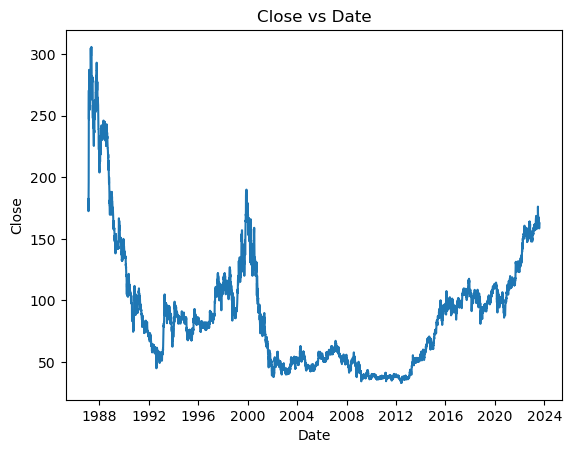

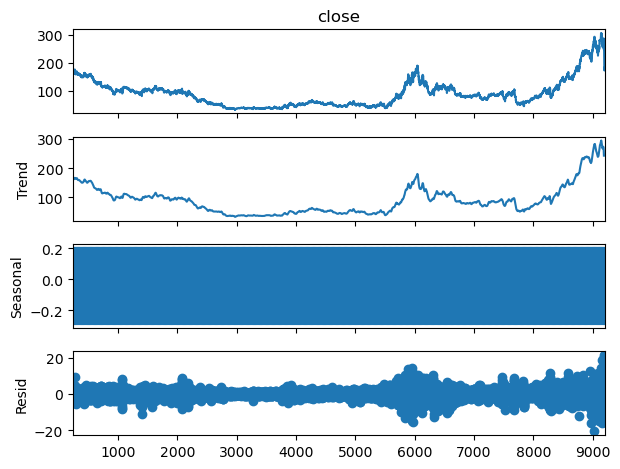

In [27]:
# トレンドや季節性の検出
plt.plot(df["date"], df["close"])
plt.title("Close vs Date")
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

result = seasonal_decompose(df["close"], period=20)
result.plot()
plt.show()

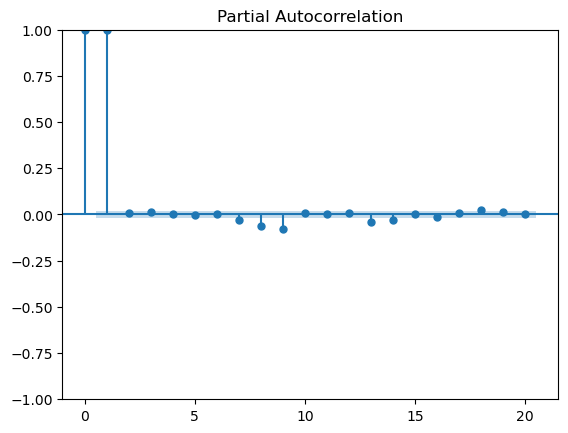

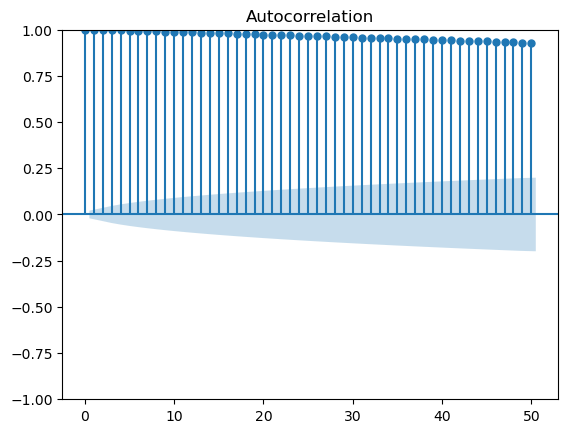

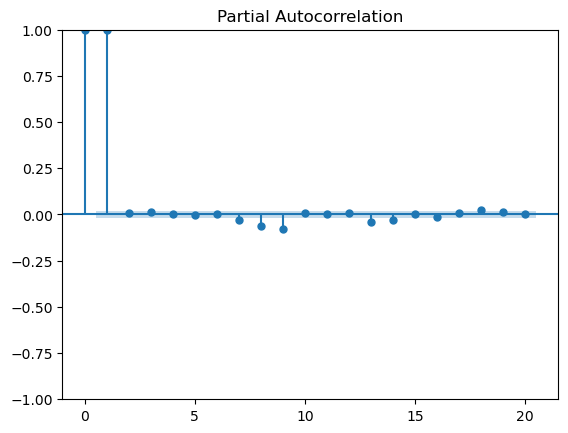

In [28]:
# 自己相関
plot_acf(df["close"], lags=50)
plot_pacf(df["close"], lags=20)

### データ前処理と特徴量エンジニアリング

In [8]:
# ラグ特徴量の生成関数
def create_lag_features(df, list_num):
    for i in list_num:
        df["log"+str(i)] = df["close"].shift(i)
    return df

In [9]:
df = load_csv_to_df("C:/Users/harry/Downloads/課題/stock_price.csv")

# ラグ特徴量の追加
df = create_lag_features(df, [1])
 
# 欠損値の補完
df.dropna(inplace=True)

feature = df.drop(["date", "close"], axis=1)
target = df[["close"]]

# 正規化
scaler_feature = MinMaxScaler()
scaler_target = MinMaxScaler()
feature_scaled = pd.DataFrame(scaler_feature.fit_transform(feature), columns=feature.columns, index=feature.index)
target_scaled = pd.DataFrame(scaler_target.fit_transform(target), columns=target.columns, index=target.index)

# 訓練用,テスト用に分割
feature_train, feature_test, target_train, target_test = train_test_split(feature_scaled, target_scaled, test_size=0.2, shuffle=False)

# テンソル化
feature_train_tensor = torch.FloatTensor(feature_train.values)
feature_test_tensor = torch.FloatTensor(feature_test.values)
target_train_tensor = torch.FloatTensor(target_train.values)
target_test_tensor = torch.FloatTensor(target_test.values)

### モデル選定とトレーニング

In [ ]:
# モデルの構築
# LATMモデル
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layers = layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, layers, batch_first=True)
        self.func = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        h0 = torch.zeros(self.layers, data.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layers, data.size(0), self.hidden_dim).requires_grad_()
        output1, _ = self.lstm(data, (h0.detach(), c0.detach()))
        output2 = self.func(output1[:, -1, :])
        return output2

In [11]:
# モデルのトレーニングを行う関数
def train_model(model, feature_train, target_train, epochs, lr):
    # 損失関数：Huber Loss
    criterion = nn.HuberLoss(reduction='mean', delta=1.0)
    # 最適化アルゴリズム：Adam
    optimizer = optim.Adam(model.parameters(), lr=lr)
                           
    model.train()
    for epoch in range(1,epochs+1):
        output = model(feature_train)
        loss = criterion(output, target_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print("epoch：" + str(epoch) + "/" + str(epochs)+",loss:"+str(loss.item()))

### モデルの実行と評価

In [12]:
# モデルの実行・評価を行う関数
def run_model(model, feature_test, target_test):
    target_test = target_test.numpy()
    # モデルの実行
    model.eval()
    with torch.no_grad():
        predictions = model(feature_test)
    predictions = predictions.numpy()

    result_predictions = scaler_target.inverse_transform(predictions)
    result_target_test = scaler_target.inverse_transform(target_test)

    # モデルの評価
    MAE = mean_absolute_error(result_target_test, result_predictions)
    RMSE = np.sqrt(mean_squared_error(result_target_test, result_predictions))
    R2 = r2_score(result_target_test, result_predictions)
    print("MAE：" + str(MAE) + " RMSE：" + str(RMSE) + " R2：" + str(R2))

    # グラフの表示
    plt.plot(result_target_test)
    plt.plot(result_predictions)
    plt.title("Actual vs Predicted")
    plt.ylabel("Close")
    plt.legend()
    plt.show()

epoch：10/100,loss:0.014127963222563267
epoch：20/100,loss:0.009357989765703678
epoch：30/100,loss:0.008770612068474293
epoch：40/100,loss:0.0077824704349040985
epoch：50/100,loss:0.006763660814613104
epoch：60/100,loss:0.005389809142798185
epoch：70/100,loss:0.0036712749861180782
epoch：80/100,loss:0.0017507114680483937
epoch：90/100,loss:0.00037035936838947237
epoch：100/100,loss:0.00014549399202223867
MAE：15.022015 RMSE：26.483244 R2：0.8564592599868774


C:\Users\harry\AppData\Local\Temp\ipykernel_13628\2315836279.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


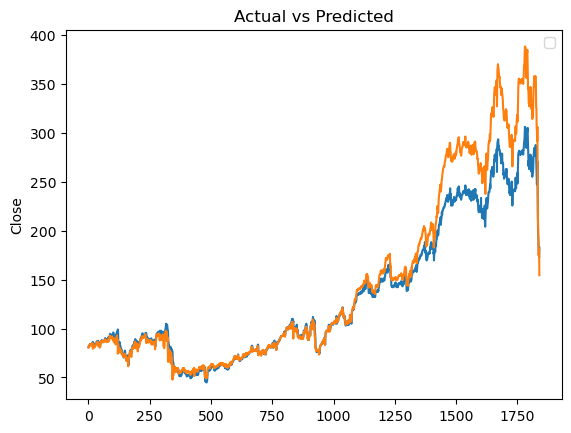

In [14]:
lstm = LSTMModel(input_dim=feature_train_tensor.shape[1], hidden_dim=64, output_dim=1, layers=2)
train_model(lstm, feature_train_tensor.unsqueeze(1), target_train_tensor, epochs=100, lr=0.001)
run_model(lstm, feature_test_tensor.unsqueeze(1), target_test_tensor)

### モデルの再トレーニング

In [22]:
df = load_csv_to_df("C:/Users/harry/Downloads/課題/stock_price.csv")

# 特徴量の追加
df = create_lag_features(df, [1,5,20,60,240])
df.dropna(inplace=True)

#特徴量選択
feature = df.drop(["date","close"], axis=1)
target = df[["close"]]

rfe = RFE(LinearRegression())
feature_rfe = rfe.fit(feature,target)  
feature_selected = feature.columns[feature_rfe.support_]

print(feature_selected)

Index(['open', 'high', 'low', 'change_rate', 'log1'], dtype='object')


In [23]:
feature = df[feature_selected]
target = df[["close"]]

# 正規化
scaler_feature = MinMaxScaler()
scaler_target = MinMaxScaler()
feature_scaled = pd.DataFrame(scaler_feature.fit_transform(feature), columns=feature.columns, index=feature.index)
target_scaled = pd.DataFrame(scaler_target.fit_transform(target), columns=target.columns, index=target.index)

# 訓練用,テスト用に分割
feature_train, feature_test, target_train, target_test = train_test_split(feature_scaled, target_scaled, test_size=0.2, shuffle=False)

# テンソル化
feature_train_tensor = torch.FloatTensor(feature_train.values)
feature_test_tensor = torch.FloatTensor(feature_test.values)
target_train_tensor = torch.FloatTensor(target_train.values)
target_test_tensor = torch.FloatTensor(target_test.values)

In [24]:
# ハイパーパラメーターチューニング
list_hiddendim = [32, 64, 128]
list_layers = range(1,5)
list_lr = [0.001, 0.01, 0.1]

best_RMSE = float('inf')
best_params = None

for hidden_dim in list_hiddendim:
    for layers in list_layers:
        for lr in list_lr:
            lstm = LSTMModel(input_dim=feature_train_tensor.shape[1], hidden_dim=hidden_dim, output_dim=1, layers=layers)
            train_model(lstm, feature_train_tensor.unsqueeze(1), target_train_tensor, epochs=100, lr=lr)

            lstm.eval()
            with torch.no_grad():
                predictions = lstm(feature_train_tensor.unsqueeze(1))
                RMSE = np.sqrt(mean_squared_error(target_train_tensor.numpy(), predictions.numpy()))

                if RMSE < best_RMSE:
                    best_RMSE = RMSE
                    best_params = {"hidden_dim": hidden_dim, "layers": layers, "lr": lr}

print(f"Best parameters: {best_params}")

epoch：10/100,loss:0.049430716782808304
epoch：20/100,loss:0.037520475685596466
epoch：30/100,loss:0.026860760524868965
epoch：40/100,loss:0.0176242683082819
epoch：50/100,loss:0.010361664928495884
epoch：60/100,loss:0.005655330140143633
epoch：70/100,loss:0.0034972738940268755
epoch：80/100,loss:0.0029302083421498537
epoch：90/100,loss:0.0027540274895727634
epoch：100/100,loss:0.0025062779895961285
epoch：10/100,loss:0.004182410426437855
epoch：20/100,loss:0.0005716887535527349
epoch：30/100,loss:0.00039788245339877903
epoch：40/100,loss:7.880858174758032e-05
epoch：50/100,loss:5.992051592329517e-05
epoch：60/100,loss:2.1267200281727128e-05
epoch：70/100,loss:1.6565059922868386e-05
epoch：80/100,loss:9.741222129378002e-06
epoch：90/100,loss:8.826154953567311e-06
epoch：100/100,loss:7.61881165090017e-06
epoch：10/100,loss:0.01060484629124403
epoch：20/100,loss:0.0023561178240925074
epoch：30/100,loss:0.0011699890019372106
epoch：40/100,loss:0.0005332333967089653
epoch：50/100,loss:0.0001780759048415348
epoch：6

epoch：10/100,loss:0.005377559922635555
epoch：20/100,loss:0.001367695047520101
epoch：30/100,loss:0.0004826980293728411
epoch：40/100,loss:0.000103978585684672
epoch：50/100,loss:5.046262594987638e-05
epoch：60/100,loss:2.0786706954822876e-05
epoch：70/100,loss:1.3901019883633126e-05
epoch：80/100,loss:9.997181223297957e-06
epoch：90/100,loss:7.64744163461728e-06
epoch：100/100,loss:6.231191036931705e-06
MAE：6.2837553 RMSE：12.674932 R2：0.9675644636154175


C:\Users\harry\AppData\Local\Temp\ipykernel_13628\2315836279.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


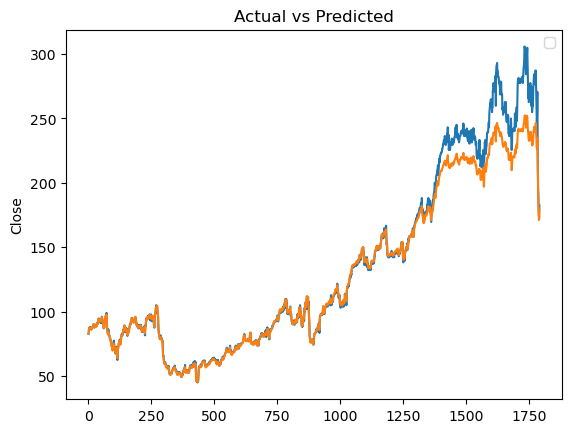

In [25]:
# 改良型予想モデル
lstm = LSTMModel(input_dim=feature_train_tensor.shape[1], hidden_dim=best_params["hidden_dim"], output_dim=1, layers=best_params["layers"])
train_model(lstm, feature_train_tensor.unsqueeze(1), target_train_tensor, epochs=100, lr=best_params["lr"])
run_model(lstm, feature_test_tensor.unsqueeze(1), target_test_tensor)

### 